In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week,\
forecast_by_week, train_test_split,update_deepAR_parameters, hyperparameter_boxplots,\
generate_model_results_by_hp_dict, plot_model_results_by_hp
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()

In [2]:
df =  pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Hyperparameter_results_19_04.csv", sep=',')

hp_search_space = {
    "num_cells": tune.grid_search([10, 20, 40]),
    "num_layers": tune.grid_search([3, 4, 5]),
    "context_length":tune.grid_search([4, 52, 104]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([8, 20, 30]),
    #"use_feat_static_real":tune.grid_search([False]),
    #"use_feat_dynamic_real":tune.grid_search([True]),
    "use_feat_static_cat":tune.grid_search([False,True]),
    "cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}

model_results_by_hp = generate_model_results_by_hp_dict(df, hp_search_space)

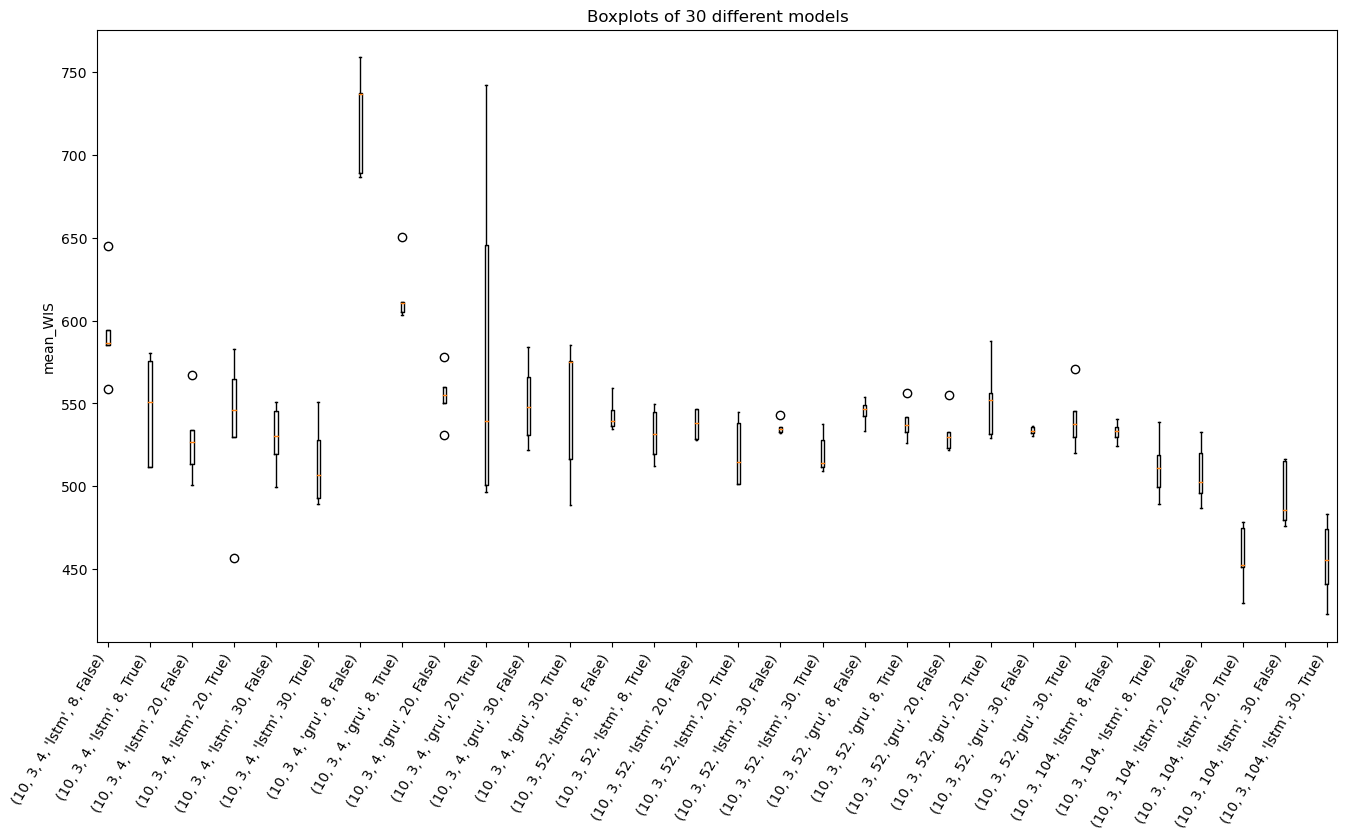

In [3]:
plot_model_results_by_hp(model_results_by_hp, number_of_plots=30, col="mean_WIS",figsize=(16, 9))

In [9]:
overall_df = pd.DataFrame()
for key in list(model_results_by_hp.keys())[:]:
    overall_df = pd.concat([overall_df, model_results_by_hp[key]])

In [14]:
added_cols = ["model_WIS_mean","model_WIS_variance","model_WIS_sd","model_time_mean","model_time_variance","model_time_sd"]
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)&("use_feat_dynamic_real" not in col)&("use_feat_static_real" not in col)]].drop_duplicates().tail(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_time_mean,model_time_variance,model_time_sd,config/cell_type,config/context_length,config/epochs,config/num_cells,config/num_layers,config/use_feat_static_cat
1112,580.697491,100.991010,10.049428,2798.551409,1.272470e+05,356.716938,lstm,52,30,20,5,False
915,581.041661,392.755380,19.818057,3678.420872,6.895367e+05,830.383447,gru,52,30,40,4,True
536,581.157779,670.689868,25.897681,3481.239957,1.087452e+05,329.765297,lstm,52,30,40,3,True
1599,581.433104,763.876134,27.638309,5462.647639,8.325558e+06,2885.404240,gru,52,30,20,5,True
585,582.233979,940.961296,30.675092,3057.850978,5.077359e+05,712.555862,gru,52,20,40,4,True
644,582.719286,361.257159,19.006766,4753.812192,1.143310e+06,1069.256530,lstm,52,30,40,5,True
1566,583.034385,5536.634790,74.408567,1152.229693,1.074076e+05,327.730990,lstm,4,8,10,5,True
1556,583.525654,570.339568,23.881783,3249.639980,5.865264e+05,765.850106,lstm,52,20,40,4,True
169,584.871270,11370.097298,106.630658,1844.486289,2.615637e+05,511.432998,gru,4,20,10,3,True
1544,586.454293,752.437451,27.430593,3681.029754,7.024288e+05,838.110272,lstm,52,30,20,4,True


324
1620
3


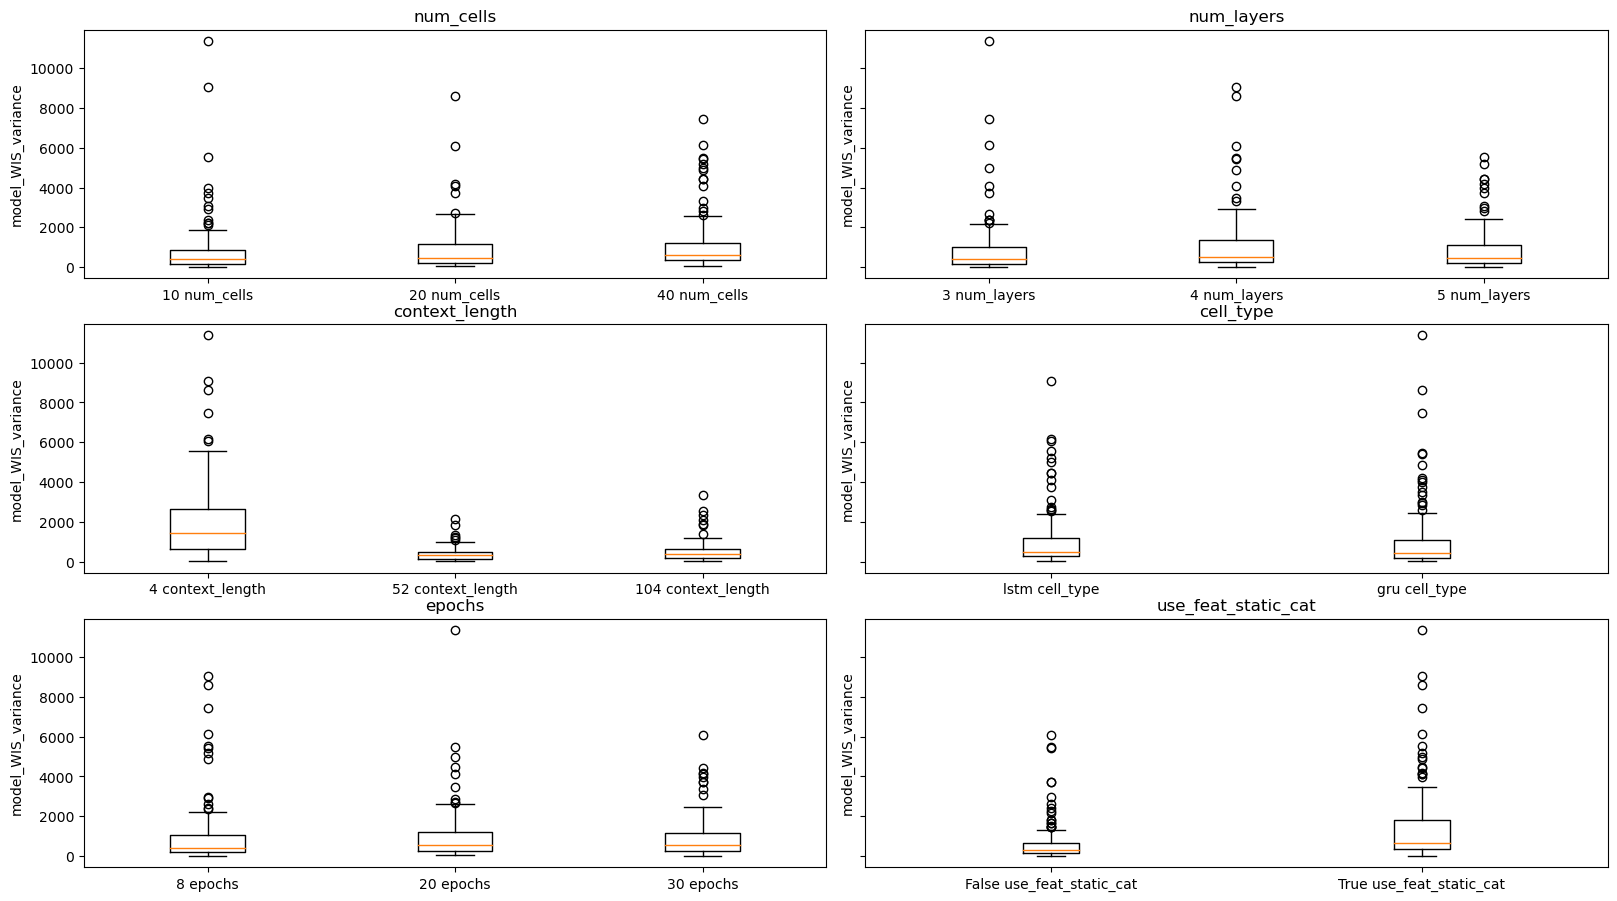

________________
3


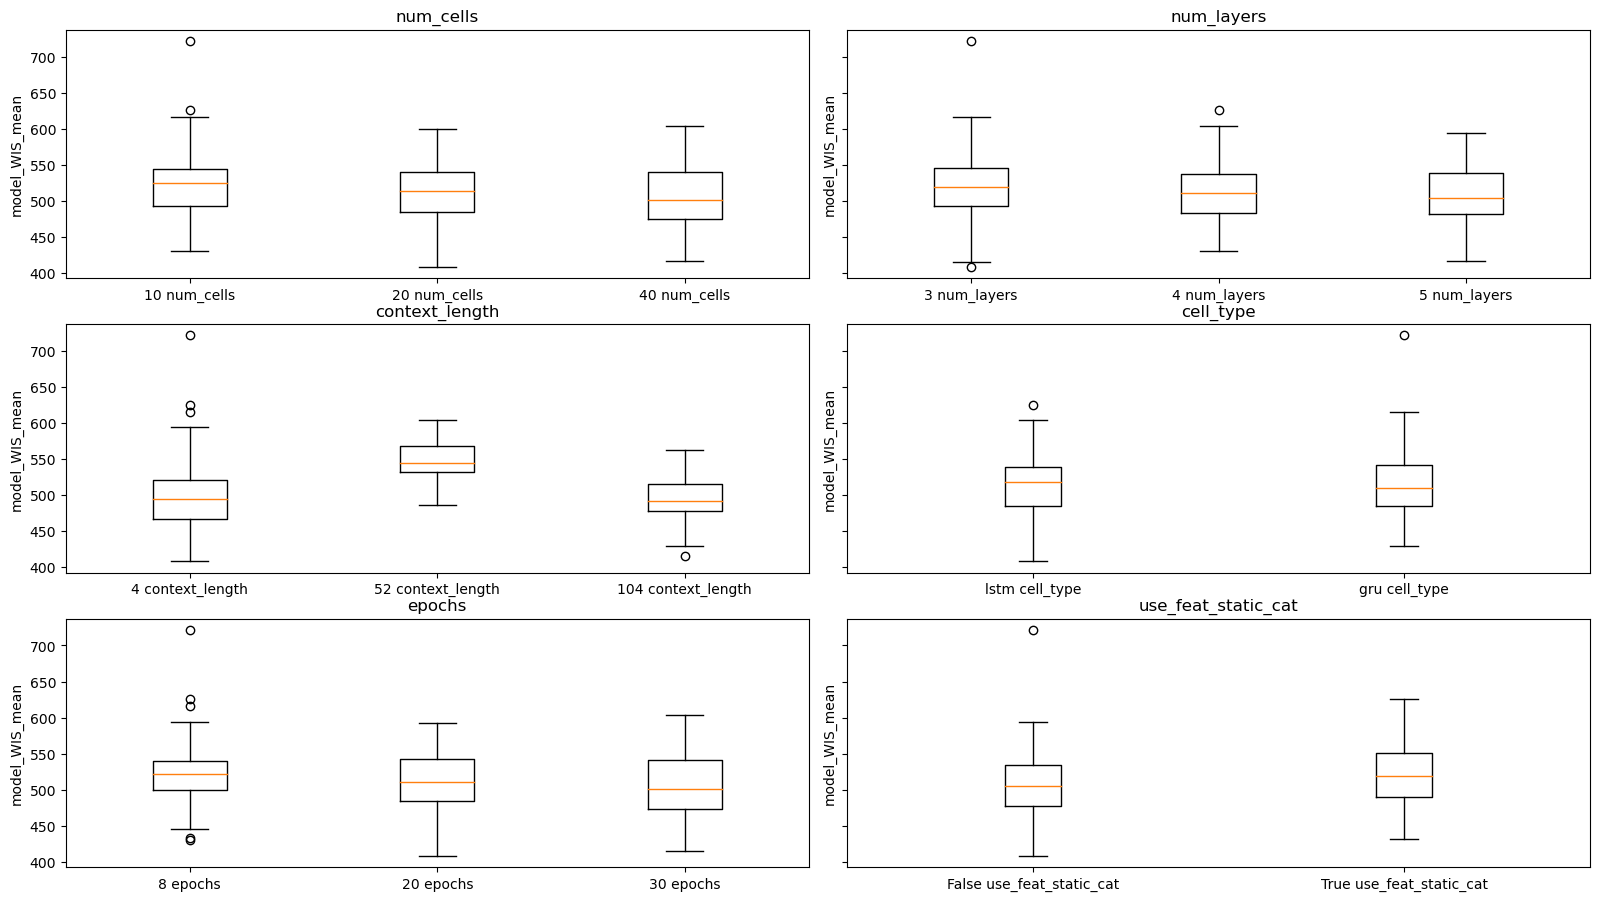

In [5]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_mean")

3


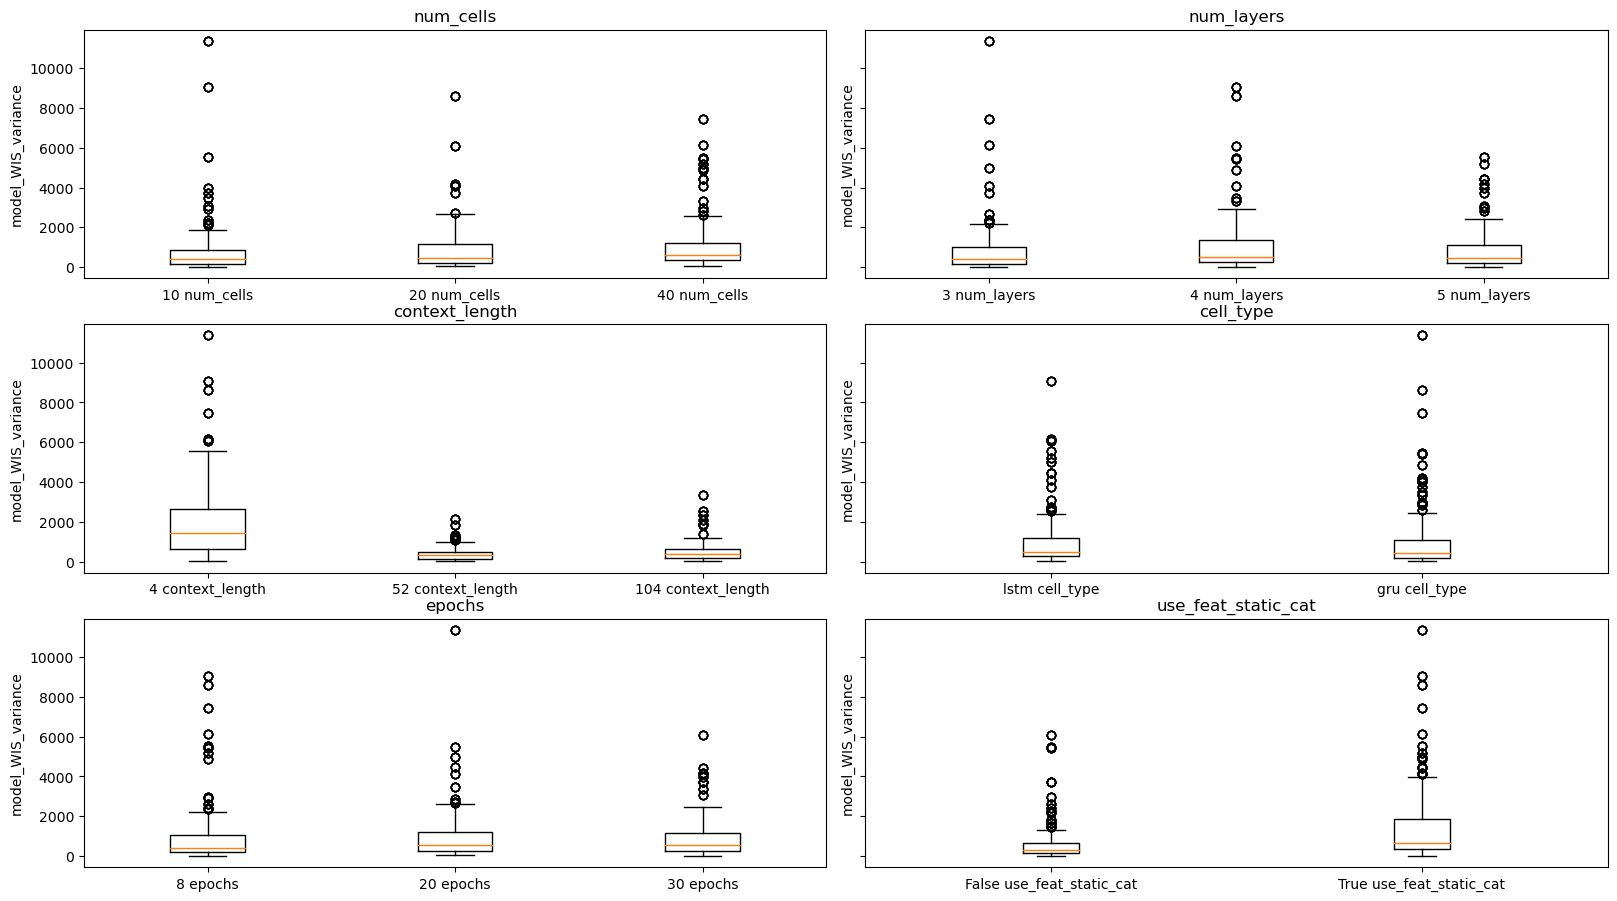

________________
3


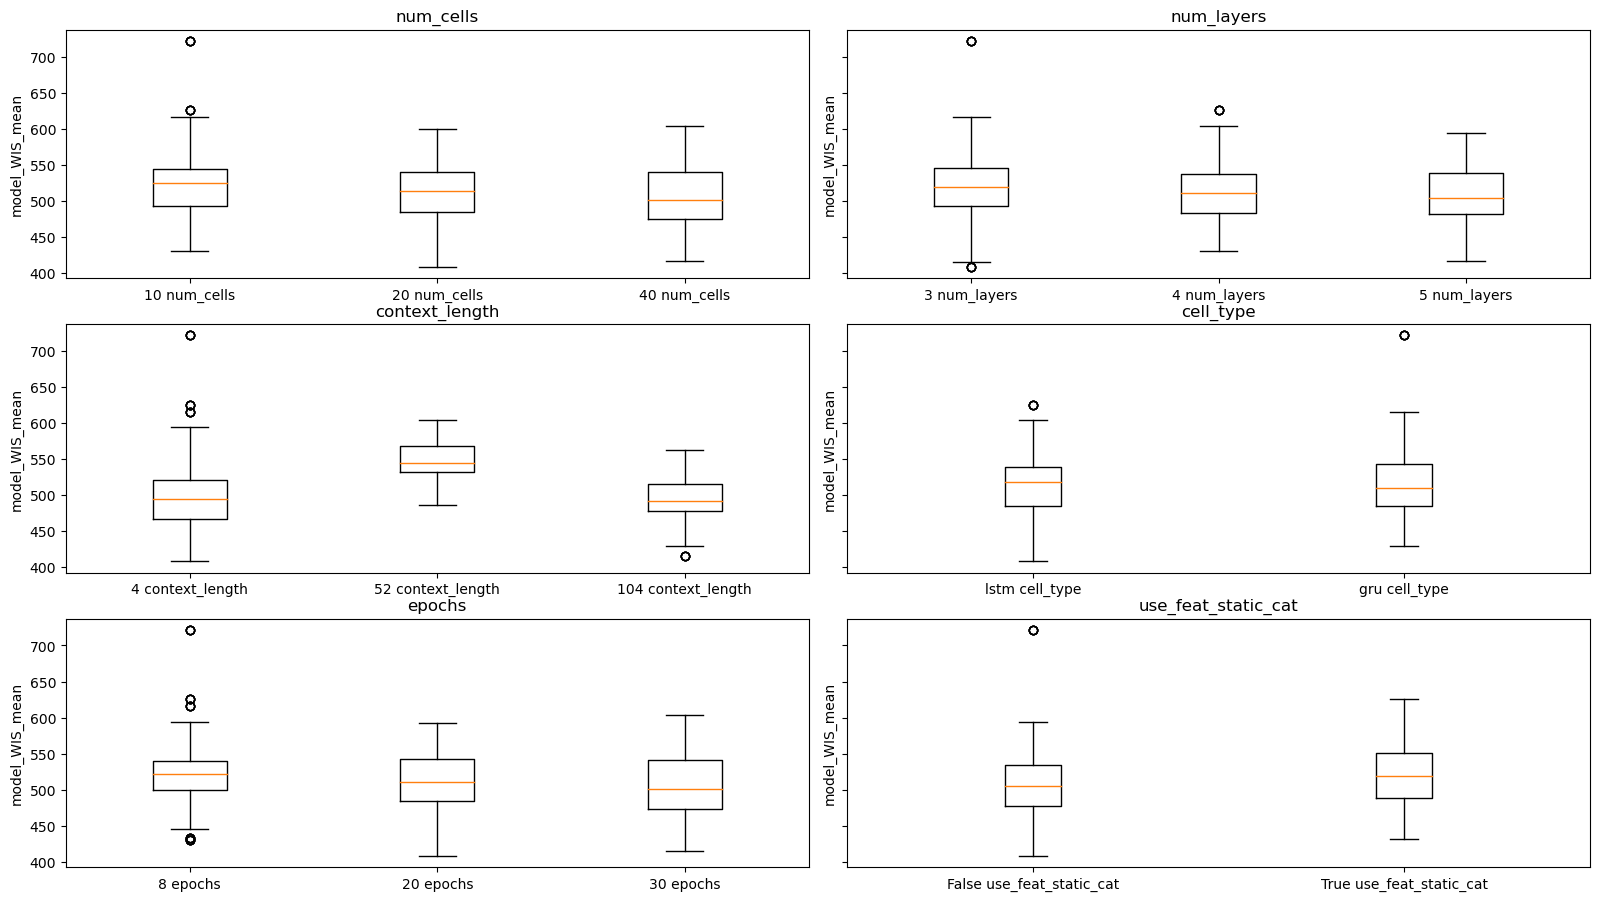

In [6]:
hyperparameter_boxplots(overall_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(overall_df, hp_search_space, col="model_WIS_mean")